# LIST OF FILES
### PRIORITIES 
>title.basics**.csv** <br>
>title.ratings**.csv** <br>
>bom.movie_gross**.csv** <br>
### SECONDARIES
>name.basics**.csv** <br>
>title.akas**.csv** <br>
>title.crew**.csv** <br>
>title.principals**.csv** <br>
>tmdbs.movies**.csv** <br>
>tn.movie_budgets**.csv** <br>
>rt.movie_info**.tsv** <br>
>rt.reviews**.tsv** <br>

### Import Necessary libraries for EDA

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.show(sns)
import numpy as np
from collections import Counter
from scipy.stats import gaussian_kde
%matplotlib inline

In [86]:
#Imdb dataset
imdb_title_basics = pd.read_csv('data/title.basics.csv')
imdb_title_akas = pd.read_csv('data/title.akas.csv')
imdb_title_crew = pd.read_csv('data/title.crew.csv')
imdb_title_principals = pd.read_csv('data/title.principals.csv')
imdb_name_basics = pd.read_csv('data/name.basics.csv')
imdb_title_ratings = pd.read_csv('data/title.ratings.csv')

#Rotten tomato dataset
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter="\t")
rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter="\t", encoding='latin-1')

#Box office Mojo dataset
bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv')

#The movies DB dataset
tmdb_movies = pd.read_csv('data/tmdb.movies.csv')

# The numbers dataset
tn_movies_budgets = pd.read_csv('data/tn.movie_budgets.csv')

## Data Cleaning for financial figures
>**tv_movies_budgets.csv** <br>
Our main focus we'll be measuring profit against budget and analyse any possible correlations. To form profit, we need revenue and cost values. As such, the only suitable table to achieve this is tv_movies_budgets.csv

In [87]:
# First we much check to see if there are any missing values. Thankfully there are non.
# But we do see there are issues with the datatypes. 
#     Both gross figures and budget figures are objects but they need to either be int or float
#     The release date should also either be in datetime or int
tn_movies_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [88]:
# Problems:
#    The financial figures should be stripped of the dollar sign and the commas and then converted to integers
tn_movies_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [89]:
# We run this code to achieve the desired formatting for the financial figures on each coloumn needed

tn_movies_budgets['production_budget'] = tn_movies_budgets['production_budget'].apply(lambda x: x.replace(',', ''))
tn_movies_budgets['production_budget'] = tn_movies_budgets['production_budget'].apply(lambda x: x.replace('$', ''))
tn_movies_budgets['production_budget'] = tn_movies_budgets['production_budget'].astype(int)

tn_movies_budgets['domestic_gross'] = tn_movies_budgets['domestic_gross'].apply(lambda x: x.replace(',', ''))
tn_movies_budgets['domestic_gross'] = tn_movies_budgets['domestic_gross'].apply(lambda x: x.replace('$', ''))
tn_movies_budgets['domestic_gross'] = tn_movies_budgets['domestic_gross'].astype(int)

tn_movies_budgets['worldwide_gross'] = tn_movies_budgets['worldwide_gross'].apply(lambda x: x.replace(',', ''))
tn_movies_budgets['worldwide_gross'] = tn_movies_budgets['worldwide_gross'].apply(lambda x: x.replace('$', ''))
tn_movies_budgets['worldwide_gross'] = tn_movies_budgets['worldwide_gross'].astype(int)

In [90]:
# We should be wary that, whilst there are no null values, there may be '0' values
tn_movies_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [91]:
# We shall search for a count of these '0' values if they exist
production_budget_0_count = (tn_movies_budgets['production_budget'] == 0).sum()
domestic_gross_0_count = (tn_movies_budgets['domestic_gross'] == 0).sum()
worldwide_gross_0_count = (tn_movies_budgets['worldwide_gross'] == 0).sum()

print(f'production_budget_0_count: {production_budget_0_count}')
print(f'domestic_gross_0_count: {domestic_gross_0_count}')
print(f'worldwide_gross_count_0: {worldwide_gross_0_count}')

# We can see there are hundreds of values missing in the domestic and gross count.
# These are essentially null values and need to be dealt with before analysis

production_budget_0_count: 0
domestic_gross_0_count: 548
worldwide_gross_count_0: 367


In [92]:
# When dealing with null values, we can use the mean, median or drop the rows
# Dropping rows is the last resort as preservation of data is important 

domestic_gross_mean = tn_movies_budgets['domestic_gross'].mean()
worldwide_gross_mean = tn_movies_budgets['worldwide_gross'].mean()

domestic_gross_median = tn_movies_budgets['domestic_gross'].median()
worldwide_gross_median = tn_movies_budgets['worldwide_gross'].median()
                        
print(f'domestic_gross_mean: {domestic_gross_mean} | domestic_gross_median: {domestic_gross_median}')
print(f'worldwide_gross_mean: {worldwide_gross_mean} | worldwide_gross_median: {worldwide_gross_median}')

# As we see, the median is substatially lower than the mean. 

domestic_gross_mean: 41873326.867001034 | domestic_gross_median: 17225945.0
worldwide_gross_mean: 91487460.90643376 | worldwide_gross_median: 27984448.5


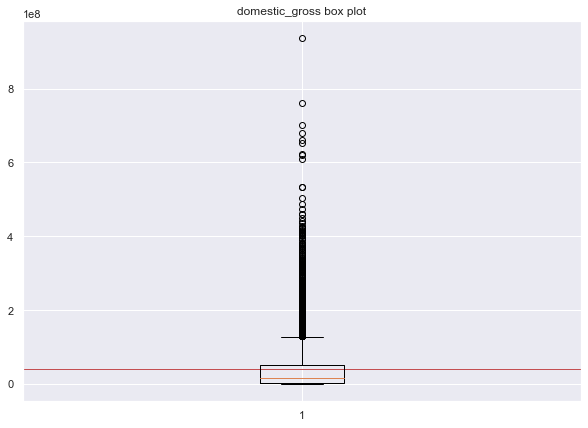

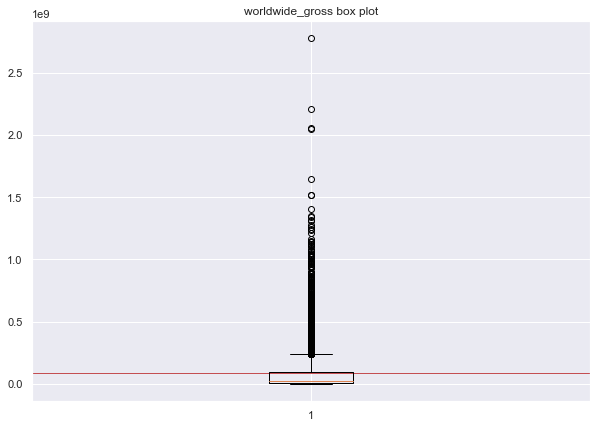

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
ax.axhline(y=domestic_gross_mean, linewidth=1, color='r')
plt.boxplot(tn_movies_budgets['domestic_gross'])
ax.set_title('domestic_gross box plot')
plt.show();

fig, ax = plt.subplots(figsize=(10,7))
ax.axhline(y=worldwide_gross_mean, linewidth=1, color='r')
plt.boxplot(tn_movies_budgets['worldwide_gross'])
ax.set_title('worldwide_gross box plot');

# From the boxplot, in both cases that there are many points beyond the 75th percentile. There is even an outlier.
# Because of this, the mean (red line) is heavily skewed. 
# To mitigate this, the median (orange line) should be prioritised.

In [94]:
# We will replace each 0 value from the domestic_gross and worldwide_gross with their respective medians
tn_movies_budgets['domestic_gross'] = tn_movies_budgets['domestic_gross'].apply(lambda x: domestic_gross_median if x==0 else x)
tn_movies_budgets['worldwide_gross'] = tn_movies_budgets['worldwide_gross'].apply(lambda x: worldwide_gross_median if x==0 else x)
                                                                            

In [95]:
# We shall turn the relase_date into a categorical variable by stripping out the years and months into separate columns
tn_movies_budgets['release_month'] = tn_movies_budgets['release_date'].apply(lambda x: x[0:3])
tn_movies_budgets['release_year'] = tn_movies_budgets['release_date'].apply(lambda x: int(x[-4:]))


In [96]:
# Now that the financial figures are numerical, we can create new columns based on simple calculations 
tn_movies_budgets['production_budget'] = tn_movies_budgets['production_budget'].apply(lambda x: x/1000000)
tn_movies_budgets['domestic_gross'] = tn_movies_budgets['domestic_gross'].apply(lambda x: x/1000000)
tn_movies_budgets['worldwide_gross'] = tn_movies_budgets['worldwide_gross'].apply(lambda x: x/1000000)


In [97]:
# We should be careful not to claim that "gross"-'budget' = 'profit' as there may be other costs outside of production cost
# To be safe, we shall call the new column production_return

tn_movies_budgets['production_return'] = tn_movies_budgets['worldwide_gross'] - tn_movies_budgets['production_budget']

# With this calculation, we shall standardise the production return values by expressing them as a percentage of the budget
tn_movies_budgets['% production_return'] = tn_movies_budgets['production_return'] / tn_movies_budgets['worldwide_gross']

## Change in financial figures over the years chart
We shall visualise our results by examining the average budget, profit and revenue per year.

In [98]:
# This will retrieve the average financial figures over the past 10 years
monthly_mean_budget_last_10_years = tn_movies_budgets[tn_movies_budgets['release_year'] >= 2011].groupby(by=['release_month'])['production_budget'].mean()


In [99]:
imdb_title_basics = pd.read_csv('data/title.basics.csv')

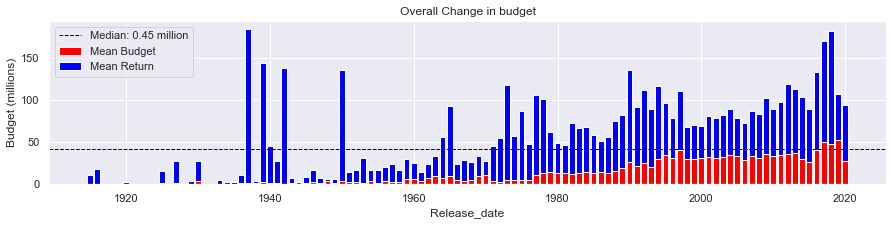

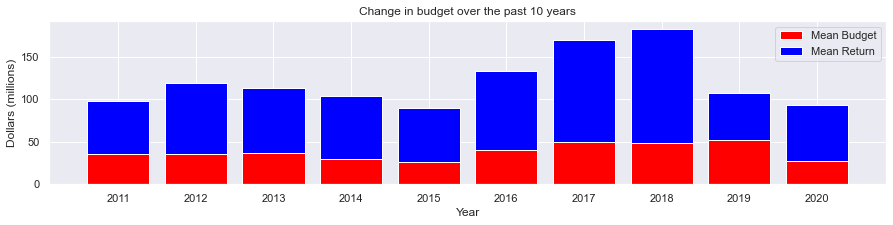

In [100]:
yearly_mean_budget = tn_movies_budgets.groupby(by=['release_year'])['production_budget'].mean()
yearly_mean_return = tn_movies_budgets.groupby(by=['release_year'])['production_return'].mean()

fig, ax = plt.subplots(figsize=(15,3))

plt.bar(
       list(yearly_mean_budget.keys()), 
       list(yearly_mean_budget),
       color = 'red',
       label = 'Mean Budget'
       )

plt.bar(
       list(yearly_mean_return.keys()), 
       list(yearly_mean_return),
       color = 'blue',
       label = 'Mean Return',
       bottom = yearly_mean_budget
       )
plt.axhline(np.median(yearly_mean_return), linewidth=1, ls='--' ,color='black', label='Median: 0.45 million')

ax.legend()
ax.set_title('Overall Change in budget')
ax.set_xlabel('Release_date')
ax.set_ylabel('Budget (millions)')


yearly_mean_budget_bar, ax = plt.subplots(figsize=(15,3))

plt.bar(
       list(yearly_mean_budget.keys())[-10:], 
       list(yearly_mean_budget)[-10:],
       color = 'red',
       label = 'Mean Budget'
       )

plt.bar(
       list(yearly_mean_return.keys())[-10:], 
       list(yearly_mean_return)[-10:],
       bottom=list(yearly_mean_budget)[-10:],
       color = 'blue',
       label = 'Mean Return',
       )


xticks = np.linspace(
                    start=min(list(yearly_mean_return.keys())[-10:]),
                    stop=max(list(yearly_mean_return.keys())[-10:]),
                    num=10
                    )

ax.legend()
ax.set_title('Change in budget over the past 10 years')
ax.set_xlabel('Year')
ax.set_ylabel('Dollars (millions)')
ax.set_xticks(xticks);

## Analysing correlation between ratings & profit

#### Preliminary merging and data cleaning

In [101]:
# Retrieve a fresh copy of 2 relevant files
imdb_title_crew = pd.read_csv('data/title.crew.csv')
imdb_title_basics = pd.read_csv('data/title.basics.csv')
imdb_title_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tconst     146144 non-null  object
 1   directors  140417 non-null  object
 2   writers    110261 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [102]:
# Drop missing rows
imdb_title_crew.dropna(axis=0, subset=['directors'], inplace=True)

In [103]:
# Strip the codes of directors and make a list of them
imdb_title_crew['directors'] = imdb_title_crew['directors'].apply(lambda x: list(str(x).split(',')))

# explode the known for titles
imdb_title_crew = imdb_title_crew.explode('directors')

# rename the directors column to tconst
imdb_title_crew.rename(columns={'directors': 'nconst'}, inplace=True)

In [104]:
# Strip the codes of genres and make a list of them
imdb_title_basics['genres'] = imdb_title_basics['genres'].apply(lambda x: list(str(x).split(',')))
imdb_title_basics = imdb_title_basics.explode('genres')

In [105]:
# before the merge, we should standardise the titles in case there are slight errors between the two tables 
imdb_title_basics['primary_title'] = imdb_title_basics['primary_title'].apply(lambda x: (x.replace(',','')).lower())
tn_movies_budgets['movie'] = tn_movies_budgets['movie'].apply(lambda x: (x.replace(',','')).lower())

In [106]:
# Merge crew and title_basics to get information on directors and the genres they made
crew_title_basics = imdb_title_crew.merge(imdb_title_basics, left_on=['tconst'], right_on=['tconst'])

In [107]:
# Merge crew_title_basics with ratings to include ratings values
crew_title_basics_ratings = crew_title_basics.merge(imdb_title_ratings, left_on=['tconst'], right_on='tconst')

In [108]:
# Merge crew_title_basics_ratings with imdb_name to now attribute the name of the director to theie unique ID
crew_title_basics_ratings_name = crew_title_basics_ratings.merge(imdb_name_basics, left_on=['nconst'], right_on=['nconst'])

In [109]:
# Merge tn_movies_budgets with imdb database to link financial figures with the imdb movies database
imdb_budgets = crew_title_basics_ratings_name.merge(tn_movies_budgets, left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [110]:
# Explode the imdb_budgets 
imdb_budgets['genres'] = imdb_budgets['genres'].apply(lambda x: list(str(x).split(',')))
imdb_budgets = imdb_budgets.explode('genres')

In [111]:
# Replace 'Music' with 'Musical'
imdb_budgets['genres'] = imdb_budgets['genres'].apply(lambda x: 'Musical' if x == 'Music' else x)

In [112]:
# Calculating a simple ROI per record
imdb_budgets['production_ROI'] = imdb_budgets['production_return'] / imdb_budgets['production_budget']

### Visualising the correlation between ratings and profit

/Users/Abass/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Abass/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Abass/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

0.7378294528788246

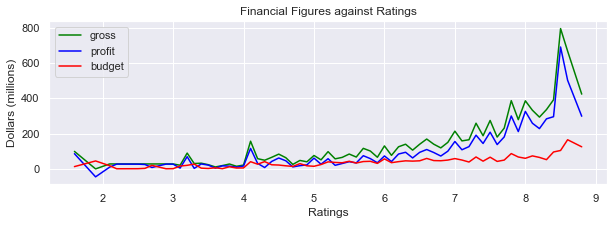

In [113]:
average_rating_vs_gross = imdb_budgets.groupby(['averagerating','primary_title']).agg({'worldwide_gross': 'mean'}).groupby('averagerating').mean()
average_rating_vs_budget = imdb_budgets.groupby(['averagerating','primary_title']).agg({'production_budget': 'mean'}).groupby('averagerating').mean()
average_rating_vs_return = imdb_budgets.groupby(['averagerating','primary_title']).agg({'production_return': 'mean'}).groupby('averagerating').mean()


fig, ax = plt.subplots(figsize = (10,3))

sns.lineplot(list(average_rating_vs_gross .to_dict()['worldwide_gross'].keys()), 
        list(average_rating_vs_gross ['worldwide_gross']),
        color = 'green',
        label = 'gross')

sns.lineplot(list(average_rating_vs_return.to_dict()['production_return'].keys()), 
        list(average_rating_vs_return['production_return']),
        color='blue',
        label='profit')

sns.lineplot(list(average_rating_vs_budget.to_dict()['production_budget'].keys()), 
        list(average_rating_vs_budget['production_budget']),
        color = 'red',
        label='budget')

ax.set_title('Financial Figures against Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Dollars (millions)');
sns.set()

#This will give us the correlation between the "profit" and ratings
np.corrcoef(list(average_rating_vs_return.to_dict()['production_return'].keys()),
            list(average_rating_vs_return['production_return']))[1][0]



### Analysis
We see little growth in profit for each point of rating gained between 0 to 6 points. However, after 6 points
profit begins to exponentially increase as ratings increase. 
Thus, at a minimum, we will require a director that can achieve 6 points on average.
Ideally, we'd also want to pick an industry that achieves a 6 point rating on average.

#### Now we shall examine the correlation between profit and ratings within the Mystery, Horror and Musical Genres

In [114]:
# Rename the crew_title_basics_ratings_name to 'imbd_joined' for ease of reference as it contains the most important imdb data
imdb_joined = crew_title_basics_ratings_name

In [115]:
# merge the these two databases to get ratings per movie
titles_and_ratings = imdb_title_basics.merge(imdb_title_ratings, left_on='tconst', right_on='tconst')

In [116]:
# Explode Genres column
titles_and_ratings = titles_and_ratings.explode('genres')

In [117]:
# Groupby genres to show their ratings and financial figures
genres_vs_rating_gross = pd.DataFrame(imdb_budgets.groupby(['genres', 'primary_title']).agg({'averagerating': 'mean', 'worldwide_gross': 'mean'}))

In [118]:
genres_vs_rating_gross.reset_index(inplace=True)

In [119]:
# Isolate the financial figures for each of the desired genres
genres_vs_rating_gross = genres_vs_rating_gross.loc[genres_vs_rating_gross['genres'].isin(['Musical', 'Mystery', 'Horror'])]


In [120]:
#imdb_joined.explode('genres')
imdb_joined['genres'] = imdb_joined['genres'].apply(lambda x: list(str(x).split(',')))
imdb_joined = imdb_joined.explode('genres')

In [121]:
# Group by year and genre to view the average ratings of each genre per year
rating_per_year = pd.DataFrame(imdb_joined.groupby(['start_year', 'genres'])['averagerating'].mean())
rating_per_year = rating_per_year.reset_index()

In [122]:
# We are only interested in these 3 genres
rating_per_year = rating_per_year[rating_per_year['genres'].isin(['Mystery', 'Musical', 'Horror'])]

In [123]:
# Group by year and genres to view their budgets per year
genres_budgets_per_year = pd.DataFrame(imdb_budgets.groupby(['start_year', 'genres']).agg({'production_budget': 'mean'})).reset_index()

# Isolate only the relevant genres
genres_budgets_per_year = genres_budgets_per_year[genres_budgets_per_year['genres'].isin(['Mystery', 'Musical', 'Horror'])]

### Visualise change in ratings per year per genre as a bar chart. Then visualise budgets per year per genre

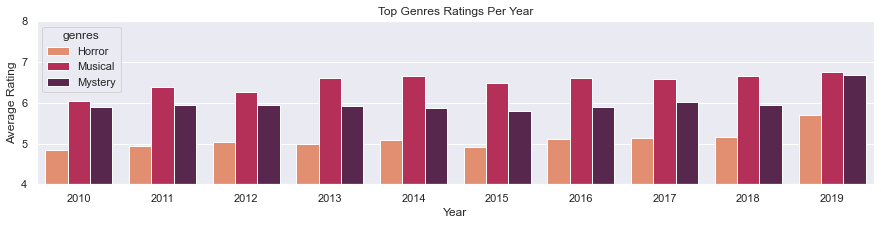

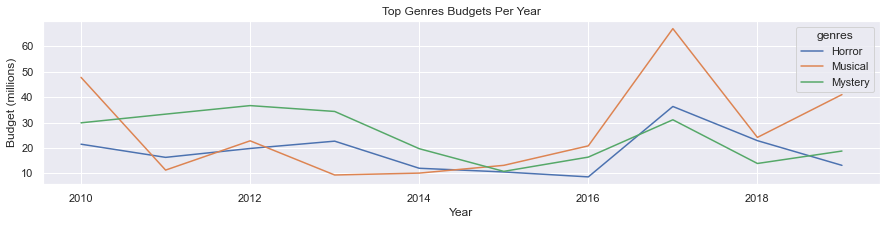

In [124]:
fig, ax1 = plt.subplots(figsize = (15,3))
palette = {'Mystery' : 'tab: red', 'Horror' : 'tab: cyan', 'Musical' : 'tab: purple'}
sns.barplot(x='start_year', 
            y='averagerating',
            color = [0.2, 0.2, 0.2],
            hue = 'genres',
            data = rating_per_year,
            palette = sns.color_palette('rocket_r', n_colors=3)
            )
ax1.set_ylim(4,8)
ax1.set_title('Top Genres Ratings Per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating')

fig, ax = plt.subplots(figsize = (15,3))
palette = {'Mystery' : 'tab: red', 'Horror' : 'tab: cyan', 'Musical' : 'tab: purple'}
sns.lineplot(x='start_year', 
            y='production_budget',
            color = [0.2, 0.2, 0.2],
            hue = 'genres',
            data = genres_budgets_per_year
            )

ax.set_title('Top Genres Budgets Per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Budget (millions)');

In [126]:
imdb_genre_financials = pd.DataFrame(imdb_budgets.groupby(
                                                          ['genres', 
                                                           'primary_title']
                                                         ).agg({
                                                               'averagerating': 'mean', 
                                                               'worldwide_gross': 'mean',
                                                               'production_budget': 'mean',
                                                               'production_return': 'mean'})).reset_index()


In [127]:
# View the correlation between budget and ratings within each of the desired genres
imdb_genre_financials.groupby('genres')[['averagerating', 'production_budget']].corr()['averagerating'].loc[['Musical', 'Mystery', 'Horror'],'production_budget']


genres                    
Musical  production_budget    0.167739
Mystery  production_budget    0.405483
Horror   production_budget    0.269898
Name: averagerating, dtype: float64

## Examine the distributionbetween ratings and profit within each genre

In [128]:
directors_ratings = imdb_title_crew.merge(imdb_title_ratings, how='inner', left_on='tconst', right_on='tconst')

In [129]:
directors_name_ratings = imdb_name_basics.merge(directors_ratings, how='inner', left_on='nconst', right_on='nconst')

In [130]:
# Create variables of financial figures for each of the desired genres
imdb_bugets_musical = imdb_budgets[imdb_budgets['genres'].isin(['Musical'])]
imdb_budgets_horror = imdb_budgets[imdb_budgets['genres'].isin(['Horror'])]
imdb_budgets_mystery = imdb_budgets[imdb_budgets['genres'].isin(['Mystery'])]

### Visualise profit and budgets distribution per genre

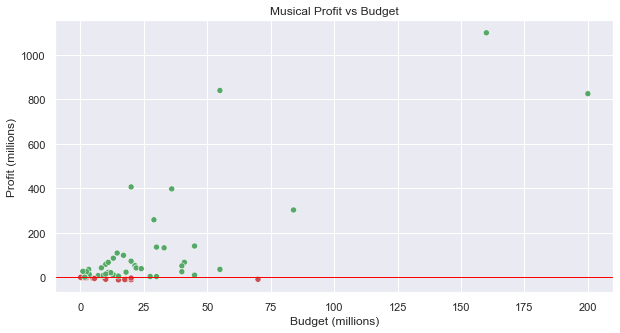

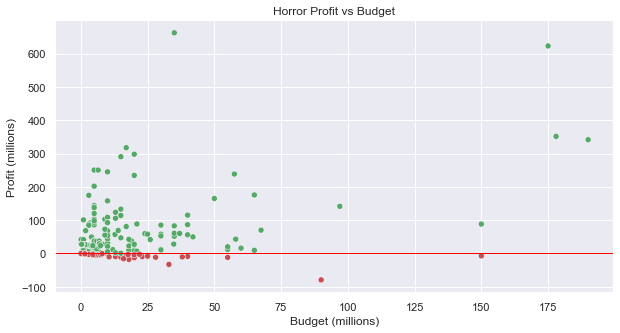

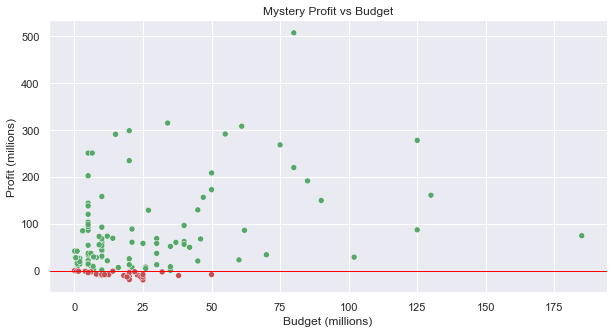

In [131]:
fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_bugets_musical['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='production_budget',
                c=col,
                data = imdb_bugets_musical)

plt.axhline(0, color='red', linewidth=1)

ax.set_title('Musical Profit vs Budget')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Budget (millions)')
plt.show();

fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_budgets_horror['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='production_budget',
                c=col,
                data = imdb_budgets_horror)

plt.axhline(0, color='red', linewidth=1)

ax.set_title('Horror Profit vs Budget')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Budget (millions)')
plt.show();

fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_budgets_mystery['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='production_budget',
                c=col,
                data = imdb_budgets_mystery)

plt.axhline(0, color='red', linewidth=1)

ax.set_title('Mystery Profit vs Budget')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Budget (millions)')
plt.show();





In [132]:
# Calculate the probability of profitable movie in each genre
musical_profitable_probability = (len(imdb_bugets_musical.loc[imdb_bugets_musical['production_return'] > 0]) / len(imdb_bugets_musical)) * 100
horror_profitable_probability = (len(imdb_budgets_horror.loc[imdb_budgets_horror['production_return'] > 0]) / len(imdb_budgets_horror)) * 100
mystery_profitable_probability = (len(imdb_budgets_mystery.loc[imdb_budgets_mystery['production_return'] > 0]) / len(imdb_budgets_mystery)) * 100


### Visualise the probability of distribution of profits within each genre

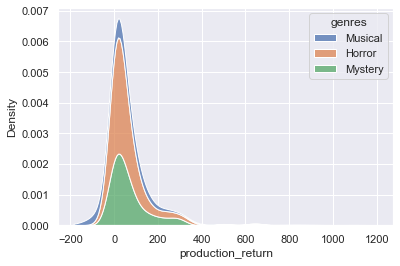

In [133]:
fig, ax = plt.subplots()
sns.kdeplot('production_return', 
            hue='genres', 
            data= imdb_budgets[imdb_budgets['genres'].isin(['Musical', 'Horror', 'Mystery'])],
           multiple = 'stack');


### Visualise the profit vs ratings per genre and isolate values above 6 ratings and profitable

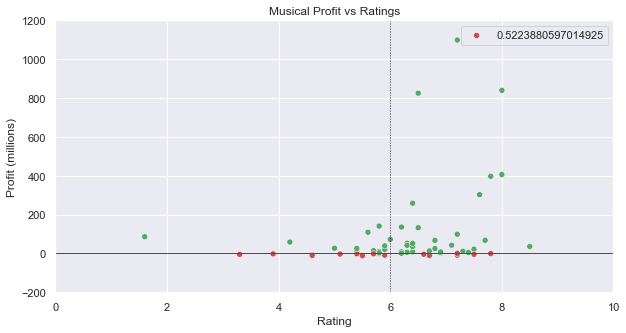

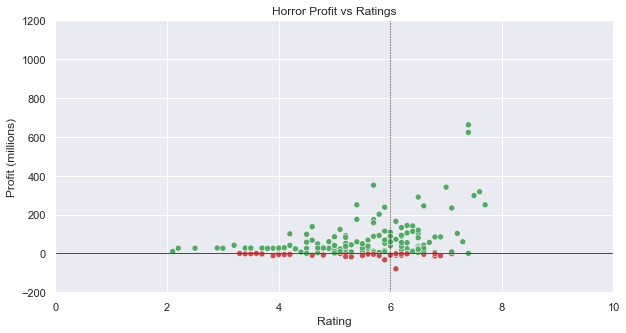

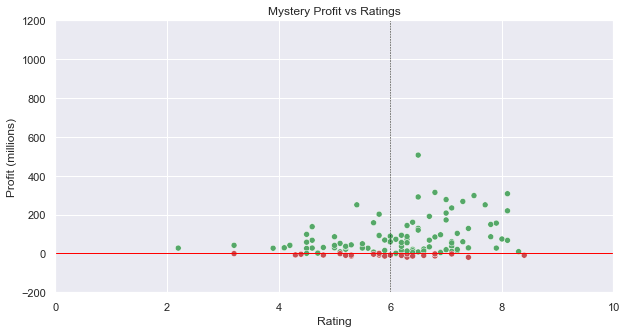

In [134]:
musical_probability = len(imdb_bugets_musical[(imdb_bugets_musical['averagerating'] >=6) & (imdb_bugets_musical['production_return'] > 0)]) / len(imdb_bugets_musical) 
horror_probability = len(imdb_budgets_horror[(imdb_budgets_horror['averagerating'] >=6) & (imdb_budgets_horror['production_return'] > 0)]) / len(imdb_budgets_horror) 
mystery_probability = len(imdb_budgets_mystery[(imdb_budgets_mystery['averagerating'] >=6) & (imdb_budgets_mystery['production_return'] > 0)]) / len(imdb_budgets_mystery) 

fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_bugets_musical['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='averagerating',
                c=col,
                data = imdb_bugets_musical,
               label=musical_probability)

plt.axhline(0, color='red', linewidth=1)
plt.axvline(6, color='black', linewidth=0.5, ls='--')

ax.set_ylim(-200,1200)
ax.set_xlim(0,10)
ax.set_title('Musical Profit vs Ratings')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Rating')
plt.show();

fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_budgets_horror['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='averagerating',
                c=col,
                data = imdb_budgets_horror)

plt.axhline(0, color='red', linewidth=1)
plt.axvline(6, color='black', linewidth=0.5, ls='--')
ax.set_ylim(-200,1200)
ax.set_xlim(0,10)
ax.set_title('Horror Profit vs Ratings')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Rating')
plt.show();

fig, ax = plt.subplots(figsize = (10,5))

col = np.where(imdb_budgets_mystery['production_return']<0, 'r', 'g')
sns.scatterplot(y = 'production_return', 
                x ='averagerating',
                c=col,
                data = imdb_budgets_mystery)

plt.axhline(0, color='red', linewidth=1)
plt.axvline(6, color='black', linewidth=0.5, ls='--')
ax.set_ylim(-200,1200)
ax.set_xlim(0,10)
ax.set_title('Mystery Profit vs Ratings')
ax.set_ylabel('Profit (millions)')
ax.set_xlabel('Rating')
plt.show();





In [135]:
musical_probability


0.5223880597014925

In [136]:
mystery_probability


0.5

In [54]:
horror_probability

0.30456852791878175